# Probabilidade de infecção por agente infeccioso
Como vimos durante a análise exploratória, cerca de 54% dos casos de SRAGs no 
Brasil não possuem uma conclusão sobre o agente infeccioso. Por isso, vamos
treinar um modelo de classificação para tentar prever qual o agente infeccioso
de um caso de SRAG.

In [56]:
import re
import time
import mlflow
import optuna
import joblib
import numpy as np
import pandas as pd
import ml_insights as mli
from pywaffle import Waffle
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

# Preprocessing
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import log_loss, f1_score, confusion_matrix, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Importando os dados
data = pd.read_csv("../data/raw/INFLUD23-16-10-2023.csv", sep=";")

/tmp/ipykernel_9882/60331149.py:2: DtypeWarning: Columns (15,53,63,91,93,143) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/raw/INFLUD23-16-10-2023.csv", sep=";")


Nem todas as colunas disponíveis no dataset serão utilizadas para a 
classificação. Após avaliação inicial, as seguintes colunas foram
selecionadas para a classificação: DT_SIN_PRI, SEM_NOT, SEM_PRI, SG_UF_NOT, 
ESTRANG, NU_IDADE_N, POV_CT, SG_UF, CS_ZONA, OUT_ANIM, FEBRE, TOSSE, GARGANTA, 
DISPNEIA, DESC_RESP, SATURACAO, DIARREIA, VOMITO, DOR_ABD, FADIGA, PERD_OLF, 
PERD_PALA, OUTRO_SIN, OUTRO_DES, VACINA, DOSE_2REF, CLASSI_FIN, CLASSI_OUT.

Primeiro, temos a data dos primeiros sintomas (DT_SIN_PRI) e a semana de
primeiros sintomas (SEM_PRI) em conjunto com a semana da notificação (SEM_NOT). 
Tais colunas foram selecionadas por certos agentes infecciosos possuirem 
sazonalidade, como é o caso do vírus influenza. As variáveis de idade 
(NU_IDADE_N), estado (SG_UF), estrangeiro (ESTRANG) e zona (CS_ZONA) foram 
selecionadas por serem variáveis demográficas que podem influenciar na 
probabilidade de infecção. Outra que pode influenciar é se o paciente teve 
contato com certos animais (OUT_ANIM). As variáveis de sintomas (FEBRE, TOSSE, 
GARGANTA, DISPNEIA, DESC_RESP, SATURACAO, DIARREIA, VOMITO, DOR_ABD, FADIGA, 
PERD_OLF, PERD_PALA, OUTRO_SIN, OUTRO_DES) foram selecionadas por serem 
sintomas comuns de SRAGs. Por último, as variáveis de vacinação (VACINA, 
DOSE_2REF) foram selecionadas por serem variáveis que revelam se o paciente foi 
vacinado contra certos agentes infecciosos. 

As variáveis de classificação (CLASSI_FIN, CLASSI_OUT) foram selecionadas por
serem as variáveis que queremos prever. A variável CLASSI_FIN é a classificação
final do caso, enquanto CLASSI_OUT é um complemento. Ambas serão unidas em uma
única variável, chamada CLASSI, que será a variável alvo do modelo.



In [3]:
# Criando lista com as colunas selecionadas
colunas_selecionadas = ["DT_SIN_PRI", "SEM_PRI", "ESTRANG", 
"SEM_NOT", "NU_IDADE_N", "SG_UF", "CS_ZONA", "OUT_ANIM", "FEBRE", "TOSSE", 
"GARGANTA", "DISPNEIA", "DESC_RESP", "SATURACAO", "DIARREIA", "VOMITO", 
"DOR_ABD", "FADIGA", "PERD_OLFT", "PERD_PALA", "OUTRO_SIN", "OUTRO_DES", 
"VACINA", "VACINA_COV", "DOSE_2REF", "CLASSI_FIN", "CLASSI_OUT"]

In [4]:
# Buscando as colunas selecionadas
data = data[colunas_selecionadas]

In [5]:
# Verificando os dados
data.head()

,DT_SIN_PRI,SEM_PRI,ESTRANG,SEM_NOT,NU_IDADE_N,SG_UF,CS_ZONA,OUT_ANIM,FEBRE,TOSSE,...,FADIGA,PERD_OLFT,PERD_PALA,OUTRO_SIN,OUTRO_DES,VACINA,VACINA_COV,DOSE_2REF,CLASSI_FIN,CLASSI_OUT
0,17/01/2023,3,2.0,3,75,MG,1.0,NaN,1.0,1.0,...,1.0,2.0,2.0,2.0,NaN,1.0,1.0,11/04/2022,4.0,NaN
1,01/01/2023,1,2.0,1,67,RJ,1.0,NaN,1.0,9.0,...,9.0,9.0,9.0,9.0,NaN,9.0,1.0,10/05/2022,4.0,NaN
2,05/01/2023,1,NaN,2,72,SP,1.0,NaN,2.0,1.0,...,2.0,2.0,2.0,2.0,NaN,NaN,1.0,19/04/2022,5.0,NaN
3,18/01/2023,3,2.0,4,46,SP,1.0,NaN,1.0,2.0,...,2.0,2.0,2.0,1.0,"FRAQUEZA,MAL ESTAR,MIALGIA",2.0,1.0,NaN,4.0,NaN
4,03/02/2023,5,2.0,6,71,SP,NaN,NaN,NaN,1.0,...,2.0,2.0,2.0,NaN,NaN,1.0,1.0,25/05/2022,4.0,NaN


In [6]:
# Verificando as dimensões do dataset
data.shape

(226763, 27)

Vamos usar o Pandas Profilling para gerar um report sobre os dados e assim decidir qual caminho seguir.

In [7]:
## Gerando o report
#profile = ProfileReport(data, title="Pandas Profiling Report")
#profile.to_file("../images/reports/INFLUD23-16-10-2023.html")

Com base no relatório, as seguintes modificações serão feitas:
- Selecionar apenas os registros com o agente infeccioso definido;
- Alterar o tipo das colunas DT_SIN_PRI e DOSE_2REF para datetime;
- Deletar os registros negativos da coluna NU_IDADE_N (Não existe idade negativa);
- Por ter 99.7% de missing, a coluna OUT_ANIM será deletada;
- Expandir a coluna OUTRO_DES para gerar novas colunas com sintomas;
- Unir a coluna CLASSI_OUT com a coluna CLASSI_FIN;
- Alterar todos os valores numéricos das colunas para o seu real valor;
- Corrigir os valores  e ausentes da coluna CLASSI_FIN;

Insights gerais:
- 28% dos dados estão ausentes.
- 0.4% dos dados são duplicados.
- Temos um problema de classificação com multiplos rótulos.

Por ter muitos valores únicos e em baixa quantidade, selecionaremos apenas os
targets com mais de 100 registros.

## Aplicando as correções no dataset

### Selecionando apenas os registros com o agente infeccioso definido

In [8]:
# Selecionando apenas os casos identificados
data = data.query("CLASSI_FIN != 4.0")

# Dropando os registros com valores nulos no target
data = data.dropna(subset=["CLASSI_FIN"])

### Alterando o tipo das colunas DT_SIN_PRI e DOSE_2REF para datetime

In [9]:
# Alterando o tipo dos dados
data["DT_SIN_PRI"] = pd.to_datetime(data["DT_SIN_PRI"], format="%d/%m/%Y")
data["DOSE_2REF"] = pd.to_datetime(data["DOSE_2REF"], format="%d/%m/%Y")

### Deletar os registros negativos da coluna NU_IDADE_N (Não existe idade negativa)

In [10]:
# Buscando apenas os registros com idade maior ou igual a zero
data = data.query("NU_IDADE_N >= 0")

### Por ter 99.7% de missing, a coluna OUT_ANIM será deletada

In [11]:
# Dropando a coluna
data = data.drop("OUT_ANIM", axis = 1)

### Expandir a coluna OUTRO_DES para gerar novas colunas com sintomas

RESULTADO: Esta abordagem não surtiu muito efeito, a sequência permanecerá 
comentada para não afetar o modelo.

In [12]:
data = data.drop("OUTRO_DES", axis = 1)

In [13]:
## Criando uma bag com os sintomas
#lista_sintomas_inicial = []
#
## Obtendo apenas os sintomas sem espaço no nome
#for sintomas in data["OUTRO_DES"].dropna():
#    if sintomas.find(" ") == -1:
#        lista_sintomas_inicial.append(sintomas)
#    else:
#        continue
#
## Obtendo os sintomas sem caracteres especiais no nome
#lista_sintomas_final = []
#for sintomas in lista_sintomas_inicial:
#    if re.search("[^a-zA-Z0-9]", sintomas) == None:
#        lista_sintomas_final.append(sintomas)
#    else:
#        continue
#
## Obter os sintomas únicos
#lista_sintomas_final = list(set(lista_sintomas_final))

In [14]:
## Criando um dicionário com listas vazia
#dict_sintomas = {sintoma:lista for sintoma, lista in zip(lista_sintomas_final, [[] for i in range(len(lista_sintomas_final))])}
#
## Verificando se a string do sintoma contém algum dos sintomas
#for sintomas in data["OUTRO_DES"]:
#    if sintomas is np.nan:
#        for key, value in dict_sintomas.items():
#            value.append(0)
#    
#    else:
#        for sintoma in lista_sintomas_final:
#            if sintomas.__contains__(sintoma):
#                dict_sintomas[sintoma].append(1)
#            else:
#                dict_sintomas[sintoma].append(0)
#                
## Criando um dataframe com os sintomas
#data_sintomas_extra = pd.DataFrame(dict_sintomas)

In [15]:
## Buscando as colunas com baixa variância
#drop_constant = DropConstantFeatures(tol=0.998)
#drop_constant.fit(data_sintomas_extra)
#features_to_maintain = [column for column in data_sintomas_extra.columns if column not in drop_constant.features_to_drop_]

In [16]:
## Dropando as colunas com baixa variância
#data_sintomas_extra = data_sintomas_extra[features_to_maintain]

In [17]:
## Dropando a coluna
#data = data.drop("OUTRO_DES", axis = 1)
#
## Concatenando os dataframes
#data = pd.concat([data, data_sintomas_extra], axis = 1)

### Unir a coluna CLASSI_OUT com a coluna CLASSI_FIN

In [18]:
# Alterando os valores numéricos para os nomes das categorias
dict_novas_cat = {1.0:"Influenza",
                  2.0:"Outro vírus",
                  3.0:3.0,
                  5.0:"Covid-19"}

# Aplicando a mudança
data["CLASSI_FIN"] = data["CLASSI_FIN"].map(dict_novas_cat)

# Buscando as classes complementares
data.loc[data["CLASSI_FIN"] == 3, "CLASSI_FIN"] = data.loc[data["CLASSI_FIN"] == 3, "CLASSI_OUT"]

# Dropando a coluna CLASSI_OUT
data = data.drop("CLASSI_OUT", axis = 1)

### Alterar todos os valores numéricos das colunas para o seu real valor;

In [19]:
# Criando as funções
func_estrangeiro = lambda num: "Sim" if num == 1 else "Não"
func_zona = lambda num: "Urbana" if num == 1 else ("Rural" if num == 2 else ("Periurbana" if num == 3 else "Ignorado"))
func_sintoma_and_vacina = lambda num: "Sim" if num == 1 else ("Não" if num == 2 else "Ignorado")

# Aplicando as alterações
data["ESTRANG"] = data["ESTRANG"].apply(func_estrangeiro)
data["CS_ZONA"] = data["CS_ZONA"].apply(func_zona)

# Criando uma lista com os sintomas
sintomas = ["FEBRE", "TOSSE", "GARGANTA", "DISPNEIA", "DESC_RESP", "SATURACAO", 
            "DIARREIA", "VOMITO", "DOR_ABD", "FADIGA", "PERD_OLFT", 
            "PERD_PALA", "OUTRO_SIN"]

# Aplicando as alterações
for sintoma in sintomas:
    data[sintoma] = data[sintoma].apply(func_sintoma_and_vacina)
    
# Criando uma lista com as vacinas
vacinas = ["VACINA", "VACINA_COV"]
for vacina in vacinas:
    data[vacina] = data[vacina].apply(func_sintoma_and_vacina)


### Corrigir os valores  e ausentes da coluna CLASSI_FIN

In [20]:
# Deletando os targets ausentes
data = data.dropna(subset=["CLASSI_FIN"])

In [21]:
outros = ["pneumonia", "PNEUMONIA COMUNITARIA", 
          "broncopnm em paciente com enfi", "klebsiella pneumonie", 
          "PNEUMONITE BRONCOASPIRATIVA", "PNEUMONITE DEVIDA A ALIMENTO",
          "DPOC , PNM BRONCOASPIRATIVA", "SINDROME GRIPAL, BRONQUIOPNEUM",
          "PNM BACTERIANA GRAN NEGAT", "PNM - IRA", "PNM INTRAHOSPITALAR",
          "PNM , IRPA", "PNEMUMONIA", "PNEUMOCYSTIS JIROVECII", 
          "PN BACTERIANA", "PNM FUNGICA", "PNM NOSOCOMIAL AVC", "PMEUMONIA",
          "PNEUMONIO COMUNITARIA", "PNM BACTERIANA BRONCOASPIRATIV", 
          "PNEUMINA", "PNEUMONIA BACTERIANA", "PNEUMONIA - DPOC",
          "PNEUMONIA BACTERIA", "PNEUMONIA NAO ESPECIFICADA J18",
          "CID J18, PNEUMONIA", "BRONCOESPASMO/PNEUMONIA", 
          "MYCOPLASMA PNEUMONIAE", "STREPTOCOCCUS PNEUMOIAL", 
          "PNM INTRA HOSPITALASR", "PNEUMONIA CID J18, BRONQUIOLIT",
          "SRAG - PNEUMOCISTOSE", "PNEUMONIA POR STAPHYLO AUREUS", 
          "SEPSES PULMONAR, PNEUMONIA ,", "PNEUMONIA, CA", 
          "PNEUMONIA, ASMA", "PNEUMONIA BACTERIANA NAO ESPEC", 
          "CID= J18 PNEUMONIA", "PNEMOCISTOSE.PNEUMONIA POR CMV", 
          "PNEUMON IA", "IRA - PNEUMONIA", "IRA - PNEUMONIA",
          "PNEUMONIA - BRONCOESPASMO", "PNM VIRAL/ COINF. BACTERIANA", 
          "IRA,PNM", "PNEUMONIA", "STREPTOCOCCUS PNEUMONIAE", "PNM",
          "PNEUMONIA VIRAL", "PNM BACTERIANA", "PNEUMONIA NAO ESPECIFICADA",
          "Outro vírus", "HIV", "DENGUE", "TUBERCULOSE", 
          "MYCOBACTERIUM TUBERCULOSIS", "MICROBACTERIA TUBERCULOSE", 
          "TEBERCULOSE", "MYCOBACTERIUM TUBERCULOSIS,", 
          "TUBERCULOSE (M. TUBERCULOSIS)", 
          "TUBERCULOSE POSITIVO BAAR", "MYCOBACTERIUM TUBERCULOSIS", "TB",
          "TUBERCULOSE PULMONAR", "VIRUS SINCICIAL RESPIRATORIO]", 
          "VIRUS SINCIAL RESPIRATORIO", "VIRUS SINCICIAL RESPIRATORIO", 
          "VIRUS SINCICIAL"]

covids = ["Covid-19", "CORNOVIRUS OC43", "CORONAVIRUS NL63", ""]

influenzas = ["Influenza", "H1N1", "HAEMOFILOS INFLUENZA", "H INFLUENZAE"]

# Criando funções para agrupar agentes semelhantes
func_agrupar_covid = lambda doenca: "Covid-19" if doenca in covids else doenca
func_agrupar_influenza = lambda doenca: "Influenza" if doenca in influenzas else doenca
func_agrupar_outros = lambda doenca: "Outro vírus" if doenca in outros else doenca

# Aplicando as funções
data["CLASSI_FIN"] = data["CLASSI_FIN"].apply(func_agrupar_covid)
data["CLASSI_FIN"] = data["CLASSI_FIN"].apply(func_agrupar_influenza)
data["CLASSI_FIN"] = data["CLASSI_FIN"].apply(func_agrupar_outros)

# Capturando apenas os registros com doenças conhecidas
data = data.query(f"CLASSI_FIN in {['Covid-19', 'Influenza', 'Outro vírus']}")

# Mapeia o target para numérico
dict_target = {"Covid-19":0, "Influenza":1, "Outro vírus":2}
data["CLASSI_FIN"] = data["CLASSI_FIN"].map(dict_target)

## Engenharia de Features

Aqui, irei criar as seguintes features:
- Tempo decorrido entre os primeiros sintomas e a notificação;
- Tempo decorrido entre a vacinação da gripe e os primeiros sintomas;
- Diferença entre a data dos primeiros sintomas e a data de reforço para covid;
- Verificar de qual região é o estado do paciente;
- Se ele apresenta multiplos sintomas;
- Mês do primeiro sintoma e da vacina;
- Se os sintomas apareceram na primeira ou segunda quinzena do mês;
- Se a vacina foi na primeira ou segunda quinzena do mês;



In [22]:
# Calculando a diferença entre as semanas epidemiológicas
data["diferenca_semana_epi"] = data["SEM_NOT"] - data["SEM_PRI"]

In [23]:

# Calculando a diferença de dias entre a data de vacinação da covid e a data de sintomas
data['DIFERENCA_DIAS_REF_COVID'] = (data['DT_SIN_PRI'] - data['DOSE_2REF']).dt.days

In [24]:
data.head()

,DT_SIN_PRI,SEM_PRI,ESTRANG,SEM_NOT,NU_IDADE_N,SG_UF,CS_ZONA,FEBRE,TOSSE,GARGANTA,...,FADIGA,PERD_OLFT,PERD_PALA,OUTRO_SIN,VACINA,VACINA_COV,DOSE_2REF,CLASSI_FIN,diferenca_semana_epi,DIFERENCA_DIAS_REF_COVID
2,2023-01-05,1,Não,2,72,SP,Urbana,Não,Sim,Não,...,Não,Não,Não,Não,Ignorado,Sim,2022-04-19,0,1,261.0
7,2023-02-22,8,Não,8,4,PR,Ignorado,Ignorado,Sim,Ignorado,...,Ignorado,Ignorado,Ignorado,Sim,Ignorado,Não,NaT,2,0,NaN
11,2023-02-13,7,Não,7,3,PR,Urbana,Não,Sim,Não,...,Não,Não,Não,Não,Ignorado,Não,NaT,2,0,NaN
16,2023-02-08,6,Não,7,89,SP,Urbana,Sim,Sim,Não,...,Não,Não,Não,Não,Ignorado,Sim,2022-04-02,0,1,312.0
18,2023-03-12,11,Não,11,5,DF,Urbana,Sim,Sim,Não,...,Não,Não,Não,Não,Ignorado,Não,NaT,2,0,NaN


In [25]:
# Criando uma lista com as UF de cada região
regiao_sul = ["PR", "SC", "RS"]
regiao_sudeste = ["SP", "RJ", "MG", "ES"]
regiao_centro_oeste = ["MS", "MT", "GO", "DF"]
regiao_norte = ["RO", "AC", "AM", "RR", "PA", "AP", "TO"]

# Criando uma função para identificar a região
func_regiao = lambda uf: "Sul" if uf in regiao_sul else("Sudeste" if uf in regiao_sudeste else("Centro-Oeste" if uf in regiao_centro_oeste else("Norte" if uf in regiao_norte else "Nordeste")))
data["REGIAO"] = data["SG_UF"].apply(func_regiao)

In [26]:
# Contando a quantidade de sintomas que o paciente apresentou
data["MAIS_DE_UM_SINTOMA"] = data[sintomas].apply(lambda x: x.str.contains("Sim").sum(), axis=1)

In [27]:
# Coletando o mês
data["MES_SIN"] = data["DT_SIN_PRI"].dt.month
data["MES_VAC"] = data["DOSE_2REF"].dt.month

In [28]:
# Verificando se o dia dos sintomas foi na primeira ou segunda quinzena do mês
data["QUINZENA_SIN"] = data["DT_SIN_PRI"].apply(lambda x: "Primeira" if x.day <= 15 else "Segunda")
data["QUINZENA_VAC"] = data["DOSE_2REF"].apply(lambda x: "Primeira" if x.day <= 15 else "Segunda")

In [29]:
# Dropando as colunas de data
data = data.drop(["DT_SIN_PRI", "DOSE_2REF"], axis = 1)

## Realizando experimentos

In [30]:
# Define o local para salvar os exoerimentos
mlflow.set_tracking_uri('../mlruns')

## Criando/acessando o experimento
#mlflow.set_experiment('Comparando modelos')

In [31]:
# Dividindo os dados em variáveis dependentes e independentes
x = data.drop(columns='CLASSI_FIN')
y = data['CLASSI_FIN']

# Dividindo os dados em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x,
                                                        y,
                                                        test_size=0.30,
                                                        random_state=200)

# Dividindo os dados em teste e calibração
x_teste, x_calib, y_teste, y_calib = train_test_split(x_teste,
                                                      y_teste,
                                                      test_size=0.35,
                                                      random_state=200)

# Dividindo os dados em dev e teste
x_dev, x_teste, y_dev, y_teste = train_test_split(x_teste,
                                                  y_teste,
                                                  test_size=0.50,
                                                  random_state=200)


In [32]:
# Obtendo as colunas categóricas
cat_cols = x.select_dtypes(include='object').columns.tolist()

# Obtendo as colunas numéricas
num_cols = x.select_dtypes(['int', 'float']).columns.tolist()

# Instanciando um KFold Estratificado
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=200) 

In [33]:
# Criando dicionário com os modelos
dict_models_scale_sensitive = {"LR": LogisticRegression(random_state=200,
                                                        class_weight='balanced',
                                                        multi_class='auto')}

dict_models_tree_based = {"LGBM": LGBMClassifier(is_unbalance=True,
                                                 objective= 'multiclass',
                                                 random_state=200),
                          "XGB": XGBClassifier(random_state=200,
                                               objective='multi:softprob'),
                          "RF": RandomForestClassifier(class_weight='balanced',
                                                       random_state=200)}

# Criando dicionário com os encoders
dict_encoders = {"OHE": OneHotEncoder(drop='first'),
                 "TE": ce.TargetEncoder(),
                 "BE": ce.BinaryEncoder(),
                 "ME": ce.MEstimateEncoder(),
                 "CE": ce.CatBoostEncoder(),
                 "GE":ce.GrayEncoder()}

dict_imputers_num = {"SIAVG": SimpleImputer(strategy='mean'),
                     "SIMEDIAN": SimpleImputer(strategy='median')}

dict_scalers = {"SS": StandardScaler()}

# Criando dicionário com os transformers
dict_transformers = {"PT": PowerTransformer(),
                     "PF": PolynomialFeatures()}

In [34]:
## Iniciando os experimentos sem transformers
#for tag, model in dict_models_scale_sensitive.items():
#    for tag_imputer, imputer in dict_imputers_num.items():
#        for tag_encoder, encoder in dict_encoders.items():
#            for tag_scaler, scaler in dict_scalers.items():
#                
#                # Gerando a tag de identificação do modelo
#                nome_modelo = f'{tag}_{tag_imputer}_{tag_encoder}_{tag_scaler}'
#                
#                with mlflow.start_run(run_name=nome_modelo):
#                    
#                    # Criando os pipeline com os transformers
#                    pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                         ('encoder', encoder)])
#                    
#                    pipe_num = Pipeline([('imputer_num', imputer),
#                                         ('scaler', scaler)])
#                    
#                    # Criando o transformador
#                    transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                                    ('num', pipe_num, num_cols)])
#                    
#                    # Criando o pipeline final
#                    pipe = Pipeline([('transformer', transformer),
#                                    ('model', model)])
#                    
#                    # Executando o cross validation
#                    cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='neg_log_loss')
#                    
#                    # Calculando a média das métricas
#                    mean_score = cross_val_scores.mean()           
#                    
#                    # Salvando a métrica da folder 1
#                    mlflow.log_metric('log_loss_fold_1', cross_val_scores[0])
#                    
#                    # Salvando a métrica da folder 2
#                    mlflow.log_metric('log_loss_fold_2', cross_val_scores[1])
#                    
#                    # Salvando a métrica da folder 3
#                    mlflow.log_metric('log_loss_fold_3', cross_val_scores[2])
#                    
#                    # Salvando a métrica da folder 4
#                    mlflow.log_metric('log_loss_fold_4', cross_val_scores[3])
#                    
#                    # Salvando a métrica da folder 5
#                    mlflow.log_metric('log_loss_fold_5', cross_val_scores[4])
#                    
#                    # Salvando as métricas
#                    mlflow.log_metric('log_loss_mean', mean_score)

In [35]:
## Iniciando os experimentos com transformers
#for tag, model in dict_models_scale_sensitive.items():
#    for tag_imputer, imputer in dict_imputers_num.items():
#        for tag_encoder, encoder in dict_encoders.items():
#            for tag_scaler, scaler in dict_scalers.items():
#                for tag_transformer, transformer in dict_transformers.items():
#                
#                    # Gerando a tag de identificação do modelo
#                    nome_modelo = f'{tag}_{tag_imputer}_{tag_encoder}_{tag_scaler}_{tag_transformer}'
#
#                    with mlflow.start_run(run_name=nome_modelo):
#                        
#                        # Criando os pipeline com os transformers
#                        pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                             ('encoder', encoder)])
#                    
#                        pipe_num = Pipeline([('imputer_num', imputer),
#                                             ('scaler', scaler),
#                                             ('transformer', transformer)])
#
#                        # Criando o transformador
#                        transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                                        ('num', pipe_num, num_cols)])
#
#                        # Criando o pipeline final
#                        pipe = Pipeline([('transformer', transformer),
#                                        ('model', model)])
#
#                        # Executando o cross validation
#                        cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='neg_log_loss')
#
#                        # Calculando a média das métricas
#                        mean_score = cross_val_scores.mean()         
#
#                        # Salvando a métrica da folder 1
#                        mlflow.log_metric('log_loss_fold_1', cross_val_scores[0])
#
#                        # Salvando a métrica da folder 2
#                        mlflow.log_metric('log_loss_fold_2', cross_val_scores[1])
#
#                        # Salvando a métrica da folder 3
#                        mlflow.log_metric('log_loss_fold_3', cross_val_scores[2])
#
#                        # Salvando a métrica da folder 4
#                        mlflow.log_metric('log_loss_fold_4', cross_val_scores[3])
#
#                        # Salvando a métrica da folder 5
#                        mlflow.log_metric('log_loss_fold_5', cross_val_scores[4])
#
#                        # Salvando as métricas
#                        mlflow.log_metric('log_loss_mean', mean_score)

In [36]:
## Iniciando os experimentos sem transformers
#for tag, model in dict_models_tree_based.items():
#    for tag_imputer, imputer in dict_imputers_num.items():
#        for tag_encoder, encoder in dict_encoders.items():
#
#                # Gerando a tag de identificação do modelo
#                nome_modelo = f'{tag}_{tag_imputer}_{tag_encoder}'
#
#                with mlflow.start_run(run_name=nome_modelo):
#
#                     # Criando os pipeline com os transformers
#                     pipe_cat = Pipeline([('imputer_cat', SimpleImputer(strategy='most_frequent')),
#                                          ('encoder', encoder)])
#                     pipe_num = Pipeline([('imputer_num', imputer)])
#
#                     # Criando o transformador
#                     transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                                      ('num', pipe_num, num_cols)])
#
#                     # Criando o pipeline final
#                     pipe = Pipeline([('transformer', transformer),
#                                     ('model', model)])
#
#                     # Executando o cross validation
#                     cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='neg_log_loss')
#
#                     # Calculando a média das métricas
#                     mean_score = cross_val_scores.mean()         
#
#                     # Salvando a métrica da folder 1
#                     mlflow.log_metric('log_loss_fold_1', cross_val_scores[0])
#
#                     # Salvando a métrica da folder 2
#                     mlflow.log_metric('log_loss_fold_2', cross_val_scores[1])
#
#                     # Salvando a métrica da folder 3
#                     mlflow.log_metric('log_loss_fold_3', cross_val_scores[2])
#
#                     # Salvando a métrica da folder 4
#                     mlflow.log_metric('log_loss_fold_4', cross_val_scores[3])
#
#                     # Salvando a métrica da folder 5
#                     mlflow.log_metric('log_loss_fold_5', cross_val_scores[4])
#
#                     # Salvando as métricas
#                     mlflow.log_metric('log_loss_mean', mean_score)

In [37]:
## Busca a tabela com os resultados
#resultados = mlflow.search_runs()
#
## calculando o tempo de treinamento em segundos
#resultados['train_time_em_segundos'] = (resultados['end_time'] - resultados['start_time']).dt.seconds
#
## Buscando as colunas para retornar
#colunas_para_retornar = ['tags.mlflow.runName', 'train_time_em_segundos', 
#                         'metrics.log_loss_fold_1', 'metrics.log_loss_fold_2', 
#                         'metrics.log_loss_fold_5', 'metrics.log_loss_fold_3', 
#                         'metrics.log_loss_fold_4', 'metrics.log_loss_mean']
## Retornando os resultados ordenados pela média
#resultados.loc[:, colunas_para_retornar].sort_values(by='metrics.log_loss_mean', ascending=False)

E o nosso modelo campeão foi o **XGBoost** com uma média de **0.55** de 
<i>log loss</i>. O modelo foi acompanhado com os seguintes transformers:
**OneHotEncoder** e **SimpleImputer** usando a **mediana**. Foi 
possível observar que todas as folds possuem um resultado muito próximo, o que 
indica que o modelo não está sofrendo de overfitting.

## Tunando o modelo vencedor

In [38]:
## Criando função para tunar o modelo
#def objective(trial):
#
#    params = {
#            'objective':'multi:softprob',
#            'eval_metric': 'logloss',
#            'max_depth': trial.suggest_int('max_depth', 3, 10),
#            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#            'subsample': trial.suggest_float('subsample', 0.5, 1),
#            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
#            'gamma': trial.suggest_float('gamma', 0, 1),
#            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1)
#        }
#    
#    # Criando os pipelines com os transformers
#    pipe_cat = Pipeline([('imputer_cat', SimpleImputer(strategy='most_frequent')),
#                        ('encoder', OneHotEncoder(drop='first'))])
#    
#    pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy='mean'))])
#
#    # Criando o transformador
#    transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                     ('num', pipe_num, num_cols)])
#
#    # Criando o pipeline final
#    pipe = Pipeline([('transformer', transformer),
#                    ('rf', XGBClassifier(**params))])
#
#    # Treinando o modelo com os dados de treino
#    pipe.fit(x_treino, y_treino)
#   
#    # Calculando a loss com os dados de desenvolvimento
#    logloss = log_loss(y_dev, pipe.predict_proba(x_dev))
#    
#    return logloss
#
## Criando o estudo de otimização
#study = optuna.create_study(direction = 'minimize')
#study.optimize(objective, n_trials = 20)

In [39]:
## Buscando os melhores parâmetros
#study.best_params

Aparentemente não houve uma melhora significativa no modelo. Devido a isso, iremos
seguir com o modelo original.

In [40]:
# Criando o pipeline final
pipe_cat = Pipeline([('imputer_cat', SimpleImputer(strategy='most_frequent')),
                    ('encoder', OneHotEncoder(drop='first'))])
pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy='median'))])

# Criando o transformador
transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                ('num', pipe_num, num_cols)])

# Criando o pipeline final
pipe = Pipeline([('transformer', transformer),
                ('model', XGBClassifier(random_state=200,
                                        objective='multi:softprob'))])

# Treinando com os dados de treino
pipe.fit(x_treino, y_treino)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['ESTRANG', 'SG_UF',
                                                   'CS_ZONA', 'FEBRE', 'TOSSE',
                                                   'GARGANTA', 'DISPNEIA',
                                                   'DESC_RESP', 'SATURACAO',
                                                   'DIARREIA', 'VOMITO',
                                                   'DOR_ABD', 'FADIGA',
                                                   'PERD_OLFT', 'PERD_PALA',
                                                   'OUTRO_SIN',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [41]:
# Computando algumas métricas com os dados de teste
print(f"Log Loss: {log_loss(y_teste, pipe.predict_proba(x_teste))}")
print(f"F1: {f1_score(y_teste, pipe.predict(x_teste), average='weighted')}")
print(f"Precision: {precision_score(y_teste, pipe.predict(x_teste), average='weighted')}")
print(f"Recall: {recall_score(y_teste, pipe.predict(x_teste), average='weighted')}")

Log Loss: 0.554814175853447
F1: 0.7752339906872141
Precision: 0.7773865854041391
Recall: 0.7888184438040345


Das pessoas que o nosso modelo classificou com determinada doença, 77% delas 
realmente tinham a doença. Já dos que realmente tinham determinada doença, nosso
modelo previu corretamente 78% delas.

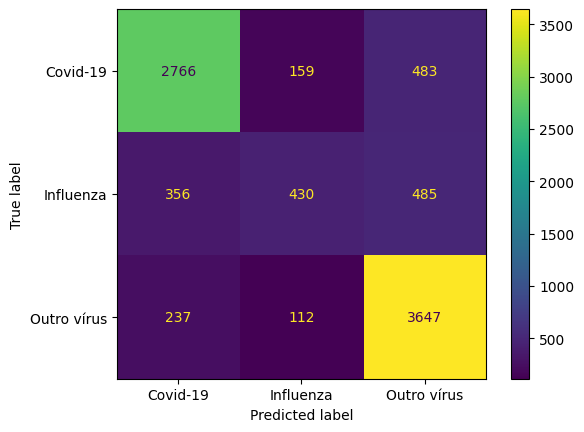

In [42]:
ConfusionMatrixDisplay(confusion_matrix(y_teste, pipe.predict(x_teste)), display_labels=['Covid-19', 'Influenza', 'Outro vírus']).plot()

É necessário melhorar o modelo para detectar melhor a Influenza.

In [64]:
# Criando lista para as latências
latency_list = []

# Calculando a latência das previsões
for _, row in x_teste.iterrows():
    
    # Início da contagem de tempo
    start_time = time.time()

    # Extrair os recursos da linha
    features = row.values.reshape(1, -1)
    
    # Fazer a previsão para a linha individual
    prediction = pipe.predict_proba(pd.DataFrame(features, columns=x_teste.columns))

    # Encerra a contagem
    end_time = time.time()
    atomic_time = end_time - start_time

    # Transforma segundo em milissegundo
    atomic_milissec = atomic_time * 1000
    
    # Adiciona o tempo em uma lista
    latency_list.append(atomic_milissec)

# calcula a média 
print(f"Latência média: {np.mean(latency_list)} milissegundos")

Latência média: 40.20151443371512 milissegundos


A latência média está boa, considerando que mais tempo será adicionado devido 
as integrações com o resto dos sistema.

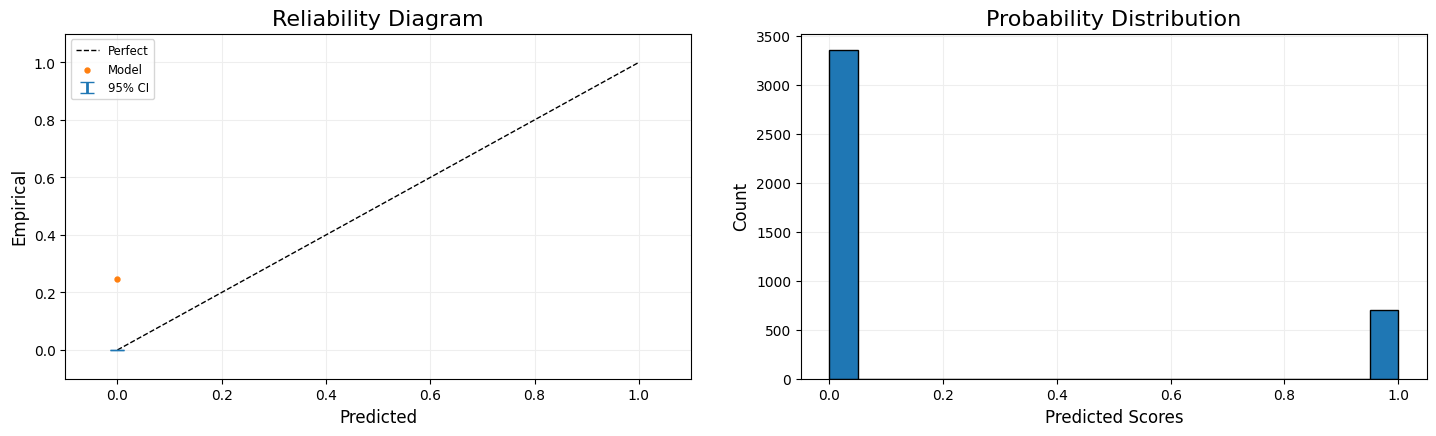

In [46]:
# Realizando predições nos dados de teste
y_pred_uncalibrated = pipe.predict_proba(x_teste)
y_pred_uncalibrated = np.argmax(y_pred_uncalibrated, axis=1)

# Plotando informações sobre a calibração
plt.figure(figsize=(15,5))
rd = mli.plot_reliability_diagram(y_teste, y_pred_uncalibrated,show_histogram=True)

In [49]:
# Prevendo as probabilidades dos dados de calibração
y_calib_probs = pipe.predict_proba(x_calib)

# Criando um Cross-Validation
cv_train_preds = mli.cv_predictions(pipe, x_treino, y_treino)

# INstanciando e treinando o calibrador
calib_mc = mli.SplineCalib()
calib_mc.fit(cv_train_preds, y_treino, verbose=True)

# Calibrando as probabilidades
calib_probs_calibrated = calib_mc.calibrate(y_calib_probs)

Calibrating Class 0
Calibrating Class 1
Calibrating Class 2


In [50]:
# Computando algumas métricas com os dados de teste
print(f"Log Loss: {log_loss(y_calib, calib_probs_calibrated)}")

Log Loss: 0.5528969131066881


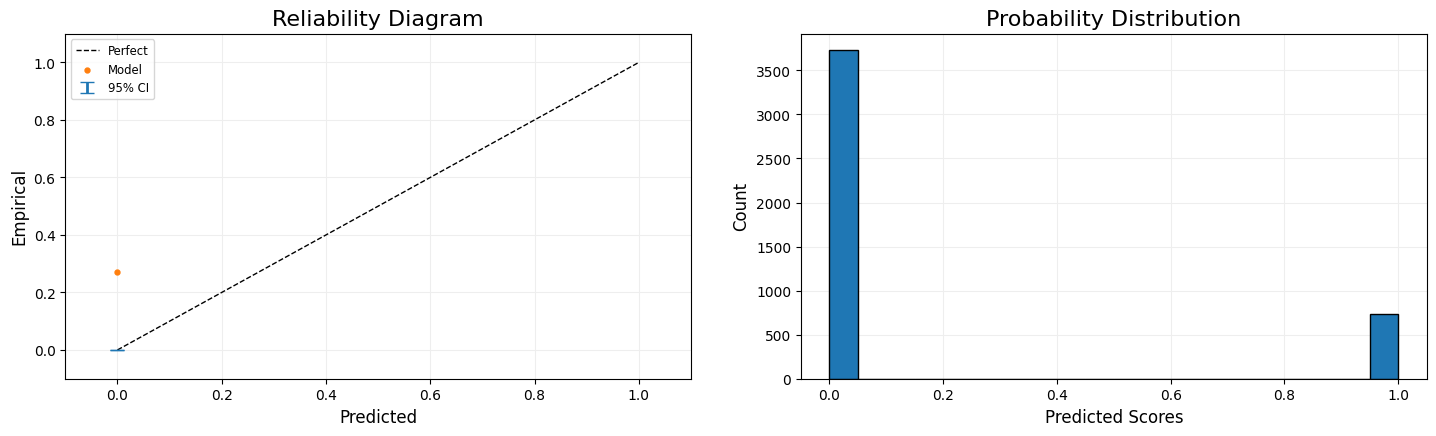

In [53]:
# Plotando informações sobre a calibração
plt.figure(figsize=(15,5))
rd = mli.plot_reliability_diagram(y_calib, np.argmax(calib_probs_calibrated, axis = 1), show_histogram=True)

Seguir as predições com esse score pode ser um pouco arriscado.

# Avaliando os resultados finais

[]

<Figure size 1500x500 with 0 Axes>

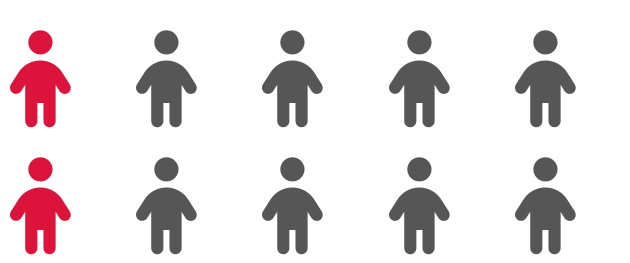

In [121]:
# Criando um gráfico de waffle mostrando a porcentagem de precisão
precisao = precision_score(y_teste, pipe.predict(x_teste), average='weighted')
erro_precisao = 1 - precisao
valores = [erro_precisao, precisao]

# Criando um gráfico de waffle
plt.figure(figsize=(15,5))

fig = plt.figure(
    FigureClass=Waffle,
    rows=2,
    columns=5,
    values=valores,
    icons='child',
    icon_size=70,
    colors=["crimson", "#555655"],

)

plt.plot()

[]

<Figure size 1500x500 with 0 Axes>

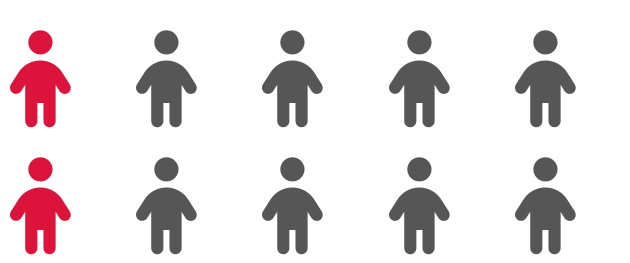

In [89]:
# Criando um gráfico de waffle mostrando a porcentagem de recall
recall =  recall_score(y_teste, pipe.predict(x_teste), average='weighted')

erro_recall = 1 - recall
valores = [erro_recall, recall]

# Criando um gráfico de waffle
plt.figure(figsize=(15,5))

fig = plt.figure(
    FigureClass=Waffle,
    rows=2,
    columns=5,
    values=valores,
    icons='child',
    icon_size=70,
    colors=["crimson", "#555655"],

)

plt.plot()

In [105]:
# Dividindo a matriz de confusão
covid = confusion_matrix(y_teste, pipe.predict(x_teste))[0]
influenza = confusion_matrix(y_teste, pipe.predict(x_teste))[1]
outro_virus = confusion_matrix(y_teste, pipe.predict(x_teste))[2]
                    
# Buscando a quantidade de previsões corretas de cada uma
covid_correto = covid[0]
influenza_correto = influenza[1]
outro_virus_correto = outro_virus[2]

[]

<Figure size 1500x500 with 0 Axes>

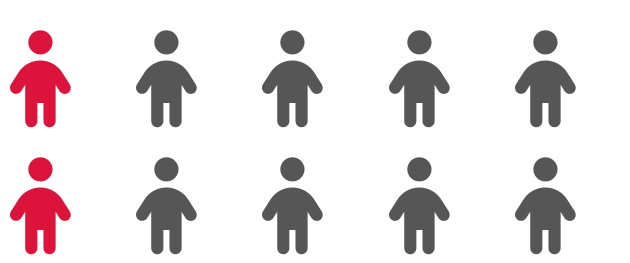

In [110]:
# Calculando a porcentagem de acerto e erro da covid
covid_porcentagem_correta = covid_correto / covid.sum()
covid_porcentagem_errada = 1 - covid_porcentagem_correta

# adicionando erro e acerto em uma lista
valores_covid = [covid_porcentagem_errada, covid_porcentagem_correta]

# Criando um gráfico de waffle
plt.figure(figsize=(15,5))

fig = plt.figure(
    FigureClass=Waffle,
    rows=2,
    columns=5,
    values=valores_covid,
    icons='child',
    icon_size=70,
    colors=["crimson", "#555655"]

)

plt.plot()

[]

<Figure size 1500x500 with 0 Axes>

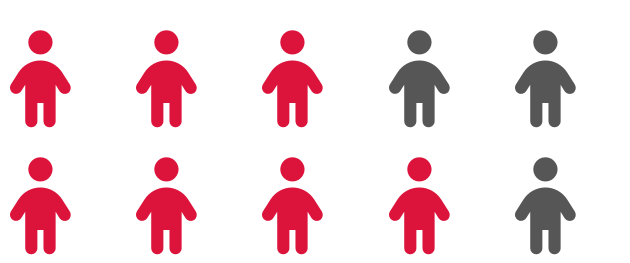

In [116]:
# Calculando a porcentagem de acerto e erro da covid
influenza_porcentagem_correta = influenza_correto / influenza.sum()
influenza_porcentagem_errada = 1 - influenza_porcentagem_correta

# adicionando erro e acerto em uma lista
valores_covid = [influenza_porcentagem_errada, influenza_porcentagem_correta]

# Criando um gráfico de waffle
plt.figure(figsize=(15,5))

fig = plt.figure(
    FigureClass=Waffle,
    rows=2,
    columns=5,
    values=valores_covid,
    icons='child',
    icon_size=70,
    colors=["crimson", "#555655"]

)

plt.plot()

[]

<Figure size 1500x500 with 0 Axes>

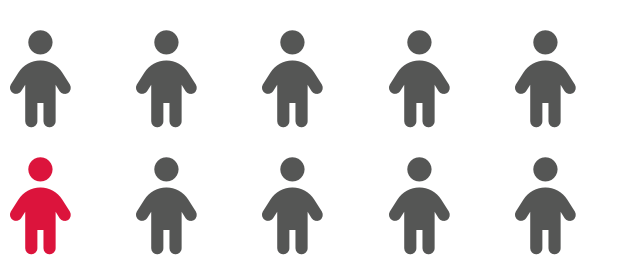

In [120]:
# Calculando a porcentagem de acerto e erro da covid
outro_virus_porcentagem_correta = outro_virus_correto / outro_virus.sum()
outro_virus_porcentagem_errada = 1 - outro_virus_porcentagem_correta

# adicionando erro e acerto em uma lista
valores_outro_virus = [outro_virus_porcentagem_errada, outro_virus_porcentagem_correta]

# Criando um gráfico de waffle
plt.figure(figsize=(15,5))

fig = plt.figure(
    FigureClass=Waffle,
    rows=2,
    columns=5,
    values=valores_outro_virus,
    icons='child',
    icon_size=70,
    colors=["crimson", "#555655"]

)

plt.plot()